In [1]:
!ls /kaggle/input/yolov3dataset
!ls /kaggle/working/yolov3

checkpoints2025      LE_cand1	LEs576_new  yolov3
LE_ATLAS_tiles_cls3  LEs576aug	log_df
ls: cannot access '/kaggle/working/yolov3': No such file or directory


In [2]:
!cp -r /kaggle/input/yolov3dataset/LE_cand1/LE_cand1 /kaggle/working/
!cp -r /kaggle/input/yolov3dataset/LE_ATLAS_tiles_cls3/LE_ATLAS_tiles_cls3 /kaggle/working/
!cp -r /kaggle/input/yolov3dataset/LEs576_new/LEs576_new/ kaggle/working/
!cp -r /kaggle/input/yolov3dataset/LEs576aug/LEs576aug /kaggle/working/
!cp -r /kaggle/input/yolov3dataset/yolov3/ /kaggle/working/


cp: cannot create directory 'kaggle/working/': No such file or directory


In [3]:
import os
os.makedirs("/kaggle/working/checkpoints_detect", exist_ok=True)
os.makedirs("/kaggle/working/checkpoints_detect/run1", exist_ok=True)

In [4]:
#!rm -rf /kaggle/working/*
#!cp -r /kaggle/input/yolov3dataset/yolov3/yolov3/yolov3.py /kaggle/working/yolov3/

In [5]:
%%writefile /kaggle/working/yolov3/configs.py
#================================================================
#
#   File name   : configs.py
#   Author      : PyLessons
#   Created date: 2020-06-04
#   Website     : https://pylessons.com/
#   GitHub      : https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3
#   Description : yolov3 configuration file
#
#================================================================

# YOLO options
YOLO_DARKNET_WEIGHTS        = "model_data/yolov3.weights"
YOLO_DARKNET_TINY_WEIGHTS   = "model_data/yolov3-tiny.weights"
YOLO_COCO_CLASSES           = "model_data/coco.names"
YOLO_STRIDES                = [8, 16, 32]
YOLO_IOU_LOSS_THRESH        = 0.5
YOLO_ANCHOR_PER_SCALE       = 3
YOLO_MAX_BBOX_PER_SCALE     = 100
YOLO_INPUT_SIZE             = 576
#YOLO_INPUT_SIZE             = 800
YOLO_ANCHORS                = [[[10,  13], [16,   30], [33,   23]],
                               [[30,  61], [62,   45], [59,  119]],
                               [[116, 90], [156, 198], [373, 326]]]
# Train options
TRAIN_YOLO_TINY             = False
TRAIN_SAVE_BEST_ONLY        = True # saves only best model according validation loss (True recommended)
TRAIN_SAVE_CHECKPOINT       = False # saves all best validated checkpoints in training process (may require a lot disk space) (False recommended)
#TRAIN_CLASSES               = "mnist/mnist.names"
TRAIN_CLASSES               = "/kaggle/working/LE_cand1/LEs_name2.txt"
#TRAIN_ANNOT_PATH            = "mnist/mnist_train.txt"
TRAIN_ANNOT_PATH            = "/kaggle/working/LE_ATLAS_tiles_cls3/train_aug12.txt"
TRAIN_LOGDIR                = "/log"
TRAIN_CHECKPOINTS_FOLDER    = "/kaggle/working/checkpoints_detect/run1"
TRAIN_MODEL_NAME            = "model"
TRAIN_LOAD_IMAGES_TO_RAM    = False # faster training, but need more RAM
#TRAIN_BATCH_SIZE            = 8
TRAIN_BATCH_SIZE            = 4
TRAIN_INPUT_SIZE            = 576
TRAIN_DATA_AUG              = False
TRAIN_TRANSFER              = False
TRAIN_FROM_CHECKPOINT       = False # "checkpoints/yolov3_custom_2"
TRAIN_LR_INIT               = 1e-4
TRAIN_LR_END                = 1e-6
TRAIN_WARMUP_EPOCHS         = 2
TRAIN_EPOCHS                = 100

# TEST options
TEST_ANNOT_PATH             = "/kaggle/working/LE_ATLAS_tiles_cls3/test_aug12.txt"
TEST_BATCH_SIZE             = 4
TEST_INPUT_SIZE             = 576
TEST_DATA_AUG               = False
TEST_DECTECTED_IMAGE_PATH   = ""
TEST_SCORE_THRESHOLD        = 0.3
TEST_IOU_THRESHOLD          = 0.45

#YOLOv3-TINY WORKAROUND
if TRAIN_YOLO_TINY:
    YOLO_STRIDES            = [16, 32, 64]    
    YOLO_ANCHORS            = [[[10,  14], [23,   27], [37,   58]],
                               [[81,  82], [135, 169], [344, 319]],
                               [[0,    0], [0,     0], [0,     0]]]

Overwriting /kaggle/working/yolov3/configs.py


In [6]:
%%writefile /kaggle/working/yolov3/dataset.py
#================================================================
#
#   File name   : dataset.py
#   Author      : PyLessons
#   Created date: 2020-05-18
#   Website     : https://pylessons.com/
#   GitHub      : https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3
#   Description : functions used to prepare dataset for custom training
#
#================================================================
# TODO: transfer numpy to tensorflow operations
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from yolov3.utils import read_class_names, image_preprocess
from yolov3.yolov3 import bbox_iou
from yolov3.configs import *

class Dataset(object):
    # Dataset preprocess implementation
    def __init__(self, dataset_type, readfits=False, clipfits=False, clipvmax=1, normfits=True, range01=True):
        self.readfits = readfits
        self.clipfits = clipfits
        self.clipvmax = clipvmax
        self.normfits = normfits
        self.range01 = range01
        self.annot_path  = TRAIN_ANNOT_PATH if dataset_type == 'train' else TEST_ANNOT_PATH
        self.input_sizes = TRAIN_INPUT_SIZE if dataset_type == 'train' else TEST_INPUT_SIZE
        self.batch_size  = TRAIN_BATCH_SIZE if dataset_type == 'train' else TEST_BATCH_SIZE
        self.data_aug    = TRAIN_DATA_AUG   if dataset_type == 'train' else TEST_DATA_AUG

        self.train_input_sizes = TRAIN_INPUT_SIZE
        self.strides = np.array(YOLO_STRIDES)
        self.classes = read_class_names(TRAIN_CLASSES)
        self.num_classes = len(self.classes)
        self.anchors = (np.array(YOLO_ANCHORS).T/self.strides).T
        self.anchor_per_scale = YOLO_ANCHOR_PER_SCALE
        self.max_bbox_per_scale = YOLO_MAX_BBOX_PER_SCALE

        self.annotations = self.load_annotations(dataset_type)
        self.num_samples = len(self.annotations)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0


    def load_annotations(self, dataset_type):
        final_annotations = []
        with open(self.annot_path, 'r') as f:
            txt = f.readlines()
            annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
        np.random.shuffle(annotations)
        
        for annotation in annotations:
            # fully parse annotations
            line = annotation.split()
            image_path, index = "", 1
            for i, one_line in enumerate(line):
                if not one_line.replace(",","").isnumeric():
                    if image_path != "": image_path += " "
                    image_path += one_line
                else:
                    index = i
                    break
            if not os.path.exists(image_path):
                raise KeyError("%s does not exist ... " %image_path)
            if TRAIN_LOAD_IMAGES_TO_RAM: image_path = cv2.imread(image_path)
            final_annotations.append([image_path, line[index:]])

        return final_annotations

    def __iter__(self):
        return self

    def __next__(self):
        with tf.device('/cpu:0'):
            self.train_input_size = random.choice([self.train_input_sizes])
            self.train_output_sizes = self.train_input_size // self.strides

            batch_image = np.zeros((self.batch_size, self.train_input_size, self.train_input_size, 3), dtype=np.float64)

            batch_label_sbbox = np.zeros((self.batch_size, self.train_output_sizes[0], self.train_output_sizes[0],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float64)
            batch_label_mbbox = np.zeros((self.batch_size, self.train_output_sizes[1], self.train_output_sizes[1],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float64)
            batch_label_lbbox = np.zeros((self.batch_size, self.train_output_sizes[2], self.train_output_sizes[2],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float64)

            batch_sbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float64)
            batch_mbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float64)
            batch_lbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float64)

            num = 0
            if self.batch_count < self.num_batchs:
                while num < self.batch_size:
                    index = self.batch_count * self.batch_size + num
                    if index >= self.num_samples: index -= self.num_samples
                    annotation = self.annotations[index]
                    image, bboxes = self.parse_annotation(annotation)
                    label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes = self.preprocess_true_boxes(bboxes)

                    batch_image[num, :, :, :] = image
                    batch_label_sbbox[num, :, :, :, :] = label_sbbox
                    batch_label_mbbox[num, :, :, :, :] = label_mbbox
                    batch_label_lbbox[num, :, :, :, :] = label_lbbox
                    batch_sbboxes[num, :, :] = sbboxes
                    batch_mbboxes[num, :, :] = mbboxes
                    batch_lbboxes[num, :, :] = lbboxes
                    num += 1
                self.batch_count += 1
                batch_smaller_target = batch_label_sbbox, batch_sbboxes
                batch_medium_target  = batch_label_mbbox, batch_mbboxes
                batch_larger_target  = batch_label_lbbox, batch_lbboxes

                return batch_image, (batch_smaller_target, batch_medium_target, batch_larger_target)
            else:
                self.batch_count = 0
                np.random.shuffle(self.annotations)
                raise StopIteration

    def random_horizontal_flip(self, image, bboxes):
        if random.random() < 0.5:
            _, w, _ = image.shape
            image = image[:, ::-1, :]
            bboxes[:, [0,2]] = w - bboxes[:, [2,0]]

        return image, bboxes

    def random_crop(self, image, bboxes):
        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            crop_xmin = max(0, int(max_bbox[0] - random.uniform(0, max_l_trans)))
            crop_ymin = max(0, int(max_bbox[1] - random.uniform(0, max_u_trans)))
            crop_xmax = max(w, int(max_bbox[2] + random.uniform(0, max_r_trans)))
            crop_ymax = max(h, int(max_bbox[3] + random.uniform(0, max_d_trans)))

            image = image[crop_ymin : crop_ymax, crop_xmin : crop_xmax]

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_xmin
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_ymin

        return image, bboxes

    def random_translate(self, image, bboxes):
        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            tx = random.uniform(-(max_l_trans - 1), (max_r_trans - 1))
            ty = random.uniform(-(max_u_trans - 1), (max_d_trans - 1))

            M = np.array([[1, 0, tx], [0, 1, ty]])
            image = cv2.warpAffine(image, M, (w, h))

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] + tx
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] + ty

        return image, bboxes

    def parse_annotation(self, annotation):
        if TRAIN_LOAD_IMAGES_TO_RAM:
            image = annotation[0]
        else:
            image_path = annotation[0]
            image = cv2.imread(image_path)
            
        bboxes = np.array([list(map(int, box.split(','))) for box in annotation[1]])

        if self.data_aug:
            image, bboxes = self.random_horizontal_flip(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_crop(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_translate(np.copy(image), np.copy(bboxes))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, bboxes = image_preprocess(np.copy(image), [self.train_input_size, self.train_input_size], np.copy(bboxes))
        
        if self.readfits:
            # replace image by fits array
            image_path = annotation[0]
            imgpath = image_path.replace('jpg', 'fits.npz') # change path to fits npz
            image = np.load(imgpath)['fitsarr']
            #image = np.dstack((image, image, image))
            #image = np.repeat( np.expand_dims(fitsarr, axis=2), repeats=3, axis=2)
            if self.clipfits:
                image = np.clip(image, a_min=-self.clipvmax, a_max=self.clipvmax)
            
            if self.normfits:
                # normalize to mean=0, std=1
                image = (image - image.mean() )/ image.std()
            
            if self.range01:
                image = (image + self.clipvmax) / (self.clipvmax * 2) # change range to [0, 1]
                print("adjust range to [0, 1]")
            print(imgpath)
        
        return image, bboxes

    def preprocess_true_boxes(self, bboxes):
        label = [np.zeros((self.train_output_sizes[i], self.train_output_sizes[i], self.anchor_per_scale,
                           5 + self.num_classes)) for i in range(3)]
        bboxes_xywh = [np.zeros((self.max_bbox_per_scale, 4)) for _ in range(3)]
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = bbox[4]

            onehot = np.zeros(self.num_classes, dtype=np.float64)
            onehot[bbox_class_ind] = 1.0
            uniform_distribution = np.full(self.num_classes, 1.0 / self.num_classes)
            deta = 0.01
            smooth_onehot = onehot * (1 - deta) + deta * uniform_distribution

            bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
            bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / self.strides[:, np.newaxis]

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((self.anchor_per_scale, 4))
                anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                anchors_xywh[:, 2:4] = self.anchors[i]

                iou_scale = bbox_iou(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32)

                    label[i][yind, xind, iou_mask, :] = 0
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = smooth_onehot

                    bbox_ind = int(bbox_count[i] % self.max_bbox_per_scale)
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / self.anchor_per_scale)
                best_anchor = int(best_anchor_ind % self.anchor_per_scale)
                xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, :] = 0
                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:] = smooth_onehot

                bbox_ind = int(bbox_count[best_detect] % self.max_bbox_per_scale)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1
        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

    def __len__(self):
        return self.num_batchs


Overwriting /kaggle/working/yolov3/dataset.py


In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import tensorflow as tf
#from tensorflow.keras.utils import plot_model
from yolov3.dataset import Dataset
#from yolov3.yolov3 import Create_Yolov3, YOLOv3, decode, compute_loss
from yolov3.utils import load_yolo_weights#, load_tiny_yolo_weights
#from yolov3.configs import *
from yolov3 import configs

2025-05-20 12:22:05.639629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747743725.833393      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747743725.887691      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
configs.TRAIN_ANNOT_PATH,configs.TEST_ANNOT_PATH,configs.TRAIN_CHECKPOINTS_FOLDER

('/kaggle/working/LE_ATLAS_tiles_cls3/train_aug12.txt',
 '/kaggle/working/LE_ATLAS_tiles_cls3/test_aug12.txt',
 '/kaggle/working/checkpoints_detect/run1')

In [9]:
Darknet_weights = configs.YOLO_DARKNET_WEIGHTS
if configs.TRAIN_YOLO_TINY:
    configs.TRAIN_MODEL_NAME = configs.TRAIN_MODEL_NAME+"_Tiny"
    Darknet_weights = configs.YOLO_DARKNET_TINY_WEIGHTS
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

if os.path.exists(configs.TRAIN_LOGDIR): shutil.rmtree(configs.TRAIN_LOGDIR)

In [10]:
%load_ext autoreload
%autoreload 2  

In [11]:
#change the path in the train_aug12.txt
import os
input_file = "/kaggle/working/LE_ATLAS_tiles_cls3/train_aug12.txt" 
output_file = "/kaggle/working/LE_ATLAS_tiles_cls3/train_aug12.txt"  

with open(input_file, "r") as f:
    content = f.read()

new_content = content.replace(
    "./dataset/LE_cand1_cls3/tiles_aug/", 
    "/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/"  
)

with open(output_file, "w") as f:
    f.write(new_content)

print(f"✅ save to: {output_file}")

✅ save to: /kaggle/working/LE_ATLAS_tiles_cls3/train_aug12.txt


In [12]:
#change the path in the test_aug12.txt
import os
input_file = "/kaggle/working/LE_ATLAS_tiles_cls3/test_aug12.txt" 
output_file = "/kaggle/working/LE_ATLAS_tiles_cls3/test_aug12.txt"  

with open(input_file, "r") as f:
    content = f.read()

new_content = content.replace(
    "./dataset/LE_cand1_cls3/tiles_aug/", 
    "/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/"  
)

with open(output_file, "w") as f:
    f.write(new_content)

print(f"✅ save to: {output_file}")

✅ save to: /kaggle/working/LE_ATLAS_tiles_cls3/test_aug12.txt


In [13]:
trainset = Dataset('train', readfits=True, clipfits=True, clipvmax=10, normfits=True, range01=False)
testset = Dataset('test', readfits=True, clipfits=True, clipvmax=10, normfits=True, range01=False)

steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = configs.TRAIN_WARMUP_EPOCHS * steps_per_epoch
total_steps = configs.TRAIN_EPOCHS * steps_per_epoch

I0000 00:00:1747743741.129617      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
len(trainset), len(testset)

(40, 20)

In [15]:
42*4/8

21.0

In [16]:
# first_annotation = testset.annotations[0]

# image, _ = testset.parse_annotation(first_annotation)
# print("Image shape:", image.shape) 
# print("Image dtype:", image.dtype)

In [17]:
img, box = next( testset )

/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/017_3_fliph.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/019_6_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/008_5_fliph.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/010_6_r270.fits.npz


In [18]:
img, box = next( trainset )

/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/016_2_fliph_r90.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/002_1_fliph_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/014_1.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/002_2_fliph_r270.fits.npz


In [19]:
img.min(), img.max(), img.mean(), img.std()

(-7.406556129455566,
 7.427102088928223,
 1.1633256132523661e-10,
 0.9999999704806126)

In [20]:
box[0][0].shape, box[1][0].shape, box[2][0].shape

((4, 72, 72, 3, 8), (4, 36, 36, 3, 8), (4, 18, 18, 3, 8))

In [21]:
box[0][0].shape, box[1][0].shape, box[2][0].shape

((4, 72, 72, 3, 8), (4, 36, 36, 3, 8), (4, 18, 18, 3, 8))

In [22]:
from yolov3.yolov3 import *

In [23]:
configs.TRAIN_ANNOT_PATH

'/kaggle/working/LE_ATLAS_tiles_cls3/train_aug12.txt'

In [24]:
%%writefile /kaggle/working/yolov3/yolov3.py
#================================================================
#
#   File name   : yolov3.py
#   Author      : PyLessons
#   Created date: 2020-06-04
#   Website     : https://pylessons.com/
#   GitHub      : https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3
#   Description : main yolov3 functions
#
#================================================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D, Lambda, Concatenate
from tensorflow.keras.regularizers import l2
from yolov3.utils import read_class_names
from yolov3.configs import *

STRIDES         = np.array(YOLO_STRIDES)
ANCHORS         = (np.array(YOLO_ANCHORS).T/STRIDES).T

class BatchNormalization(BatchNormalization):
    # "Frozen state" and "inference mode" are two separate concepts.
    # `layer.trainable = False` is to freeze the layer, so the layer will use
    # stored moving `var` and `mean` in the "inference mode", and both `gama`
    # and `beta` will not be updated !
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)


def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
    if downsample:
        input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'

    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    if bn:
        conv = BatchNormalization()(conv)
    if activate == True:
        conv = LeakyReLU(alpha=0.1)(conv)

    return conv

def residual_block(input_layer, input_channel, filter_num1, filter_num2):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
    conv = convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

    residual_output = Concatenate()([short_cut, conv])
    return residual_output

def upsample(input_layer):
    def upsample_func(x):
        return tf.image.resize(x, (x.shape[1] * 2, x.shape[2] * 2), method='nearest')
    return Lambda(upsample_func)(input_layer)

def darknet53(input_data):
    input_data = convolutional(input_data, (3, 3,  3,  32))
    input_data = convolutional(input_data, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_data = residual_block(input_data,  64,  32, 64)

    input_data = convolutional(input_data, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_data = residual_block(input_data, 128,  64, 128)

    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_data = residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data

def darknet19_tiny(input_data):
    input_data = convolutional(input_data, (3, 3, 3, 16))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 16, 32))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 32, 64))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 64, 128))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 128, 256))
    route_1 = input_data
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 256, 512))
    input_data = MaxPool2D(2, 1, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 512, 1024))

    return route_1, input_data

def YOLOv3(input_layer, NUM_CLASS):
    # After the input layer enters the Darknet-53 network, we get three branches
    route_1, route_2, conv = darknet53(input_layer)
    # See the orange module (DBL) in the figure above, a total of 5 Subconvolution operation
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 13, 13, 255] 
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1,  512,  256))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)

    conv = Concatenate()([conv, route_2])
    conv = convolutional(conv, (1, 1, 768, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))

    # conv_mbbox is used to predict medium-sized objects, shape = [None, 26, 26, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = Concatenate()([conv, route_1])
    conv = convolutional(conv, (1, 1, 384, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    
    # conv_sbbox is used to predict small size objects, shape = [None, 52, 52, 255]
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)
        
    return [conv_sbbox, conv_mbbox, conv_lbbox]

def YOLOv3_tiny(input_layer, NUM_CLASS):
    # After the input layer enters the Darknet-53 network, we get three branches
    route_1, conv = darknet19_tiny(input_layer)

    conv = convolutional(conv, (1, 1, 1024, 256))
    conv_lobj_branch = convolutional(conv, (3, 3, 256, 512))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 26, 26, 255]
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)
    
    conv = Concatenate()([conv, route_1])
    conv_mobj_branch = convolutional(conv, (3, 3, 128, 256))
    # conv_mbbox is used to predict medium size objects, shape = [None, 13, 13, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_mbbox, conv_lbbox]

def Create_Yolov3(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    if TRAIN_YOLO_TINY:
        conv_tensors = YOLOv3_tiny(input_layer, NUM_CLASS)
    else:
        conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)

    YoloV3 = tf.keras.Model(input_layer, output_tensors)
    return YoloV3

def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    def decode_func(x):
        conv_shape       = tf.shape(x)
        batch_size       = conv_shape[0]
        output_size      = conv_shape[1]

        conv = tf.reshape(x, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

        conv_raw_dxdy = conv[:, :, :, :, 0:2] # offset of center position     
        conv_raw_dwdh = conv[:, :, :, :, 2:4] # Prediction box length and width offset
        conv_raw_conf = conv[:, :, :, :, 4:5] # confidence of the prediction box
        conv_raw_prob = conv[:, :, :, :, 5: ] # category probability of the prediction box 

        # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
        y = tf.range(output_size, dtype=tf.int32)
        y = tf.expand_dims(y, -1)
        y = tf.tile(y, [1, output_size])
        x = tf.range(output_size,dtype=tf.int32)
        x = tf.expand_dims(x, 0)
        x = tf.tile(x, [output_size, 1])

        xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
        xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
        xy_grid = tf.cast(xy_grid, tf.float32)

        # Calculate the center position of the prediction box:
        pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
        # Calculate the length and width of the prediction box:
        pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

        pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
        pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
        pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

        # calculating the predicted probability category box object
        return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)
    
    return Lambda(decode_func)(conv_output)

def bbox_iou(boxes1, boxes2):
    #print("compute bbox_iou")

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area

def bbox_giou(boxes1, boxes2):
    print("compute bbox_giou")
    ###
    boxes1 = tf.cast(boxes1, tf.float32)
    boxes2 = tf.cast(boxes2, tf.float32)
    
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    # Calculate the iou value between the two bounding boxes
    iou = inter_area / union_area

    # Calculate the coordinates of the upper left corner and the lower right corner of the smallest closed convex surface
    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    # Calculate the area of the smallest closed convex surface C
    enclose_area = enclose[..., 0] * enclose[..., 1]

    # Calculate the GIoU value according to the GioU formula  
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

# testing (should be better than giou)
def bbox_ciou(boxes1, boxes2):
    
    boxes1_coor = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_coor = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left = tf.maximum(boxes1_coor[..., 0], boxes2_coor[..., 0])
    up = tf.maximum(boxes1_coor[..., 1], boxes2_coor[..., 1])
    right = tf.maximum(boxes1_coor[..., 2], boxes2_coor[..., 2])
    down = tf.maximum(boxes1_coor[..., 3], boxes2_coor[..., 3])

    c = (right - left) * (right - left) + (up - down) * (up - down)
    iou = bbox_iou(boxes1, boxes2)

    u = (boxes1[..., 0] - boxes2[..., 0]) * (boxes1[..., 0] - boxes2[..., 0]) + (boxes1[..., 1] - boxes2[..., 1]) * (boxes1[..., 1] - boxes2[..., 1])
    d = u / c

    ar_gt = boxes2[..., 2] / boxes2[..., 3]
    ar_pred = boxes1[..., 2] / boxes1[..., 3]

    ar_loss = 4 / (np.pi * np.pi) * (tf.atan(ar_gt) - tf.atan(ar_pred)) * (tf.atan(ar_gt) - tf.atan(ar_pred))
    alpha = ar_loss / (1 - iou + ar_loss + 0.000001)
    ciou_term = d + alpha * ar_loss

    return iou - ciou_term


def compute_loss(pred, conv, label, bboxes, i=0, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))
    ###
    pred = tf.cast(pred, tf.float32)
    conv = tf.cast(conv, tf.float32)
    label = tf.cast(label, tf.float32)
    bboxes = tf.cast(bboxes, tf.float32)
    
    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]  # xywh,
    respond_bbox  = label[:, :, :, :, 4:5]  # label whether a box contains objects
    label_prob    = label[:, :, :, :, 5:]   # label class, dimension= Number of class 

    giou = tf.expand_dims( bbox_giou(pred_xywh, label_xywh), axis=-1)
    
    # change to iou loss
    #giou = tf.expand_dims(bbox_iou(pred_xywh, label_xywh), axis=-1)

    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1 - giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    # Find the value of IoU with the real box The largest prediction box
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    # If the largest iou is less than the threshold, it is considered that the prediction box contains no objects, then the background box
    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < YOLO_IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    # Calculate the loss of confidence
    # we hope that if the grid contains objects, then the network output prediction box has a confidence of 1 and 0 when there is no object.
    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss

Overwriting /kaggle/working/yolov3/yolov3.py


In [25]:
if TRAIN_TRANSFER:
    Darknet = Create_Yolov3(input_size=YOLO_INPUT_SIZE)
    load_yolo_weights(Darknet, Darknet_weights) # use darknet weights
    #load_tiny_yolo_weights(Darknet, Darknet_weights) # use darknet weights
    print("train start from darknet weights")

yolo = Create_Yolov3(input_size=YOLO_INPUT_SIZE, training=True, CLASSES=TRAIN_CLASSES)
if TRAIN_FROM_CHECKPOINT:
    try:
        yolo.load_weights(TRAIN_FROM_CHECKPOINT)
    except ValueError:
        print("Shapes are incompatible, transfering Darknet weights")
        TRAIN_FROM_CHECKPOINT = False

if TRAIN_TRANSFER and not TRAIN_FROM_CHECKPOINT:
    for i, l in enumerate(Darknet.layers):
        layer_weights = l.get_weights()
        if layer_weights != []:
            try:
                yolo.layers[i].set_weights(layer_weights)
            except:
                print("skipping", yolo.layers[i].name)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [26]:
yolo = Create_Yolov3(input_size=YOLO_INPUT_SIZE, training=True, CLASSES=TRAIN_CLASSES)

In [27]:
optimizer = tf.keras.optimizers.Adam()

In [28]:
writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

def train_step(image_data, target, ioutype='mIoU'):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            ###loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES, ioutype=ioutype)
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, yolo.trainable_variables)
        optimizer.apply_gradients(zip(gradients, yolo.trainable_variables))

        # update learning rate
        # about warmup: https://arxiv.org/pdf/1812.01187.pdf&usg=ALkJrhglKOPDjNt6SHGbphTHyMcT0cuMJg
        global_steps.assign_add(1)
        if global_steps < warmup_steps:# and not TRAIN_TRANSFER:
            lr = global_steps / warmup_steps * TRAIN_LR_INIT
        else:
            lr = TRAIN_LR_END + 0.5 * (TRAIN_LR_INIT - TRAIN_LR_END)*(
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
        ###optimizer.lr.assign(lr.numpy())
        optimizer.learning_rate.assign(lr.numpy())
        # writing summary data
        ###
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.learning_rate, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()
        

    ###
    #return global_steps.numpy(), optimizer.lr.numpy(), giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()
    return global_steps.numpy(), optimizer.learning_rate.numpy(), giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [29]:
validate_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
def validate_step(image_data, target, ioutype='mIoU'):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=False)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            ###loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES, ioutype=ioutype)
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES)
            
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss
        
    return giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [30]:
df_loss = pd.DataFrame(columns=['epoch', 'giou_loss', 'conf_loss', 'prob_loss', 'total_loss'])
df_loss_val = pd.DataFrame(columns=['epoch', 'giou_val_loss', 'conf_val_loss', 'prob_val_loss', 'total_val_loss'])

In [31]:
configs.TRAIN_CHECKPOINTS_FOLDER,configs.TRAIN_MODEL_NAME

('/kaggle/working/checkpoints_detect/run1', 'model')

In [32]:
print("Final checkpoint path:", os.path.join(configs.TRAIN_CHECKPOINTS_FOLDER, "model_miou_train_aug12_ep0.weights.h5"))

Final checkpoint path: /kaggle/working/checkpoints_detect/run1/model_miou_train_aug12_ep0.weights.h5


In [33]:
for epoch in range(0, 61, 5):
    print(epoch)

0
5
10
15
20
25
30
35
40
45
50
55
60


In [34]:
%%time 

#modelname = 'model_miou_v1'  # v1 LE_cand1, miou, clip [-10, 10], normalized, 
# modelname = 'model_miou_v2'  # v2 LE_cand1, miou, clip [-10, 10], normfits=False, range [0, 1] 
#modelname = 'model_miou_train_aug2'  #  LE_cand1, train_aug2, miou, clip [-10, 10], normfits=True
modelname = 'model_miou_train_aug1'  #  LE_cand1, train_aug2, miou, clip [-10, 10], normfits=True

#modelname = 'model_miou_train_aug2_range01'  #  LE_cand1, train_aug2, miou, clip [-10, 10], normfits=False, range[0, 1]
#modelname = 'model_miou_train_aug3_range01'  #  LE_cand1, train_aug3, miou, clip [-10, 10], normfits=False, range[0, 1]

#modelname = 'model_iou_v2'  # v2 LE_cand1, iou, clip [-10, 10], normalized
#modelname = 'model_miou_v3'  # v3 LE_cand1, miou, clip [-1, 1],  normalized 
#modelname = 'model_miou_v4'  # v4 LE_cand1, miou, clip [-10, 10], not normalized
#modelname = 'model_iop_v5'    # v5 LE_cand1, iop, clip [-10, 10],  normalized
# main
ioutype = 'mIoU'
epoch0 = 0
TRAIN_EPOCHS = 61
best_val_loss = 1000 # should be large at start
for epoch in range(TRAIN_EPOCHS):

    count, giou_loss, conf_loss, prob_loss, total_loss = 0., 0, 0, 0, 0
    for image_data, target in trainset:
        results = train_step(image_data, target, ioutype=ioutype)
        cur_step = results[0]%steps_per_epoch
        print("epoch:{:2.0f} step:{:5.0f}/{}, lr:{:.6f}, giou_loss:{:7.2f}, conf_loss:{:7.2f}, prob_loss:{:7.2f}, total_loss:{:7.2f}"
              .format(epoch, cur_step, steps_per_epoch, results[1], results[2], results[3], results[4], results[5]))

        count += 1
        giou_loss += results[2]
        conf_loss += results[3]
        prob_loss += results[4]
        total_loss += results[5]
    
    # append loss to dataframe
    #row_loss = {'epoch': epoch, 'giou_loss': results[2], 'conf_loss': results[3], 'prob_loss':results[4], 'total_loss':results[5]}
    
    row_loss = {'epoch': epoch, 'giou_loss': giou_loss/count, 'conf_loss': conf_loss/count, 'prob_loss':prob_loss/count, 'total_loss':total_loss/count}
    ###
    #df_loss = df_loss.append(row_loss, ignore_index=True)
    df_loss = pd.concat([df_loss, pd.DataFrame([row_loss])], ignore_index=True)
    ### test  
    if len(testset) == 0:
        print("configure TEST options to validate model")
        yolo.save_weights(os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME))
        continue
        
    count, giou_val, conf_val, prob_val, total_val = 0., 0, 0, 0, 0
    for image_data, target in testset:
        results = validate_step(image_data, target, ioutype=ioutype)
        count += 1
        giou_val += results[0]
        conf_val += results[1]
        prob_val += results[2]
        total_val += results[3]
        
        print("giou_val", results[0], "conf_val", results[1], "prob_val", results[2], "total_val", results[3])
    # writing validate summary data
    with validate_writer.as_default():
        tf.summary.scalar("validate_loss/total_val", total_val/count, step=epoch)
        tf.summary.scalar("validate_loss/giou_val", giou_val/count, step=epoch)
        tf.summary.scalar("validate_loss/conf_val", conf_val/count, step=epoch)
        tf.summary.scalar("validate_loss/prob_val", prob_val/count, step=epoch)
    validate_writer.flush()
        
    print("\n\ngiou_val_loss:{:7.2f}, conf_val_loss:{:7.2f}, prob_val_loss:{:7.2f}, total_val_loss:{:7.2f}\n\n".
          format(giou_val/count, conf_val/count, prob_val/count, total_val/count))

    # append val_loss to dataframe
    row_val_loss = {'epoch': epoch, 'giou_val_loss': giou_val/count, 'conf_val_loss': conf_val/count, 'prob_val_loss':prob_val/count, 'total_val_loss':total_val/count}
    #df_loss_val = df_loss_val.append(row_val_loss, ignore_index=True)###
    df_loss_val = pd.concat([df_loss_val, pd.DataFrame([row_val_loss])], ignore_index=True)
    # save weights
    if epoch%5 == 0:
        TRAIN_MODEL_NAME = "{}_ep{}.weights.h5".format( modelname, epoch+epoch0)
        #TRAIN_MODEL_NAME = "{}_ep{}.weights.h5"
        yolo.save_weights( os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME) )

import shutil
import os
shutil.make_archive('/kaggle/working/checkpoints_detect', 'zip', "/kaggle/working/checkpoints_detect")

/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/016_2_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/013_5_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/013_5_fliph_r90.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/006_5_r270.fits.npz


I0000 00:00:1747743745.915351      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


compute bbox_giou
compute bbox_giou
compute bbox_giou
epoch: 0 step:    2/40, lr:0.000002, giou_loss:  34.53, conf_loss:3513.14, prob_loss:  56.89, total_loss:3604.55
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/014_0_r90.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_0_fliph_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_4_fliph_r90.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_0.fits.npz
compute bbox_giou
compute bbox_giou
compute bbox_giou
epoch: 0 step:    3/40, lr:0.000004, giou_loss:  49.38, conf_loss:3795.61, prob_loss:  52.31, total_loss:3897.30
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/002_2.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/004_4_fliph.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/018_1_fliph_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/012_2_r90.fits.npz
compute bbox_giou
compute bbox_giou
compute bbox_giou
epoch: 0 step:    4/40, lr:0.000005, giou_loss:  46.43, conf_loss:3785.07, pro

<timed exec>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/005_7_fliph_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/010_6_r90.fits.npz
compute bbox_giou
compute bbox_giou
compute bbox_giou
giou_val 40.777103 conf_val 3484.6929 prob_val 73.71211 total_val 3599.1821
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_1_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/017_0.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_1_r90.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/019_6_r90.fits.npz
compute bbox_giou
compute bbox_giou
compute bbox_giou
giou_val 48.05409 conf_val 3484.693 prob_val 87.472115 total_val 3620.2195
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/005_8_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/019_6.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/001_2_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/017_0_r270.fits.npz
compute bbox_giou
compute bbox_giou
compute bbox_giou
giou_val 48.655876 conf_val 3485.4

<timed exec>:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_4_fliph_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_2_fliph.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_0_fliph_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/002_1_fliph.fits.npz
compute bbox_giou
compute bbox_giou
compute bbox_giou
epoch: 1 step:    1/40, lr:0.000051, giou_loss:  35.35, conf_loss:1855.47, prob_loss:  50.48, total_loss:1941.30
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_0_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_0_fliph_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/003_2_r180.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/018_3_fliph_r180.fits.npz
compute bbox_giou
compute bbox_giou
compute bbox_giou
epoch: 1 step:    2/40, lr:0.000052, giou_loss:  27.32, conf_loss:1812.99, prob_loss:  39.96, total_loss:1880.27
/kaggle/working/LE_ATLAS_tiles_cls3/tiles_aug/011_6_fliph_r270.fits.npz
/kaggle/working/LE_ATLAS_tiles_cls3/tile

'/kaggle/working/checkpoints_detect.zip'

In [35]:
save_dir = "/kaggle/working/detect_df/"
os.makedirs(save_dir, exist_ok=True) 

In [36]:
df_loss.to_csv("/kaggle/working/detect_df/df_loss_miou_model_train_aug1.csv", index=False)
df_loss_val.to_csv("/kaggle/working/detect_df/df_loss_val_miou_model_train_aug1.csv", index=False)
print("saved loss to csv")

saved loss to csv


In [37]:
df_loss = pd.read_csv('/kaggle/working/detect_df/df_loss_miou_model_train_aug1.csv')
df_loss_val = pd.read_csv('/kaggle/working/detect_df/df_loss_val_miou_model_train_aug1.csv')

/tmp/ipykernel_19/2196151800.py:4: RuntimeWarning: invalid value encountered in log10
  y2 = np.log10( df_loss_val['total_val_loss'].values )


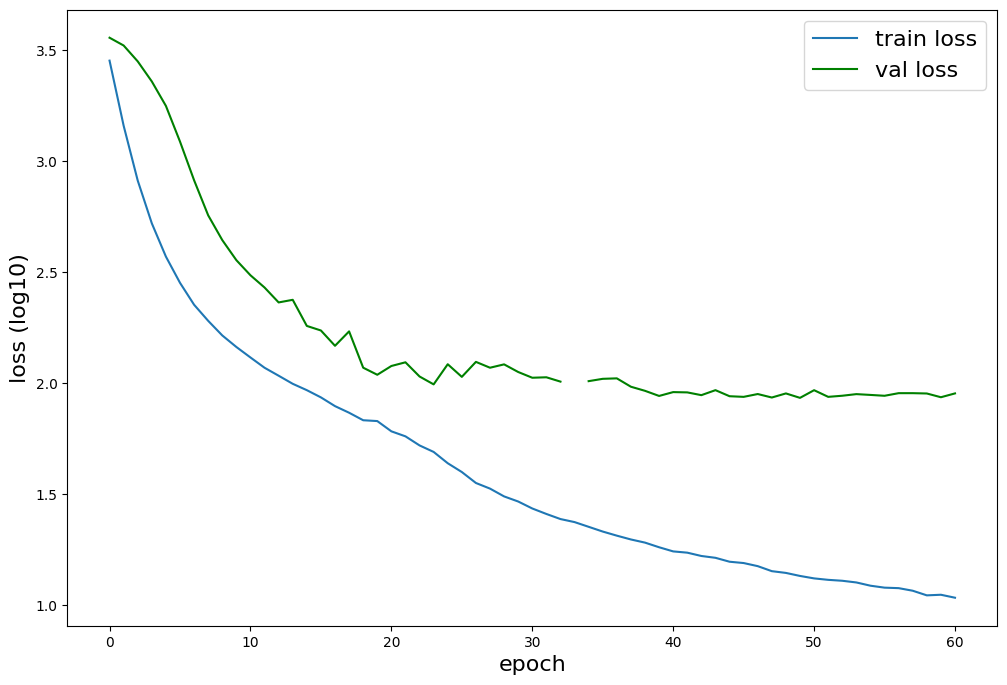

In [38]:
#x = df_loss['epoch'].values
x = df_loss.index.to_list()
y1 = np.log10( df_loss['total_loss'].values  )
y2 = np.log10( df_loss_val['total_val_loss'].values )

plt.figure(figsize=(12,8))
plt.plot(x, y1, label='train loss')

plt.plot(df_loss_val.index.to_list() , y2, label='val loss', color='green')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss (log10)', fontsize=16)
plt.legend(fontsize=16)

#plt.xlim([300, 400])
#plt.ylim([0, 200])

In [39]:
import shutil
import os
shutil.make_archive('/kaggle/working/detect_df', 'zip', "/kaggle/working/detect_df")

'/kaggle/working/detect_df.zip'